In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

In [37]:
from sklearn.preprocessing import LabelEncoder
churn = pd.read_csv('train.csv')
le = LabelEncoder()
binary_var = ['Gender', 'ParentalControl', 'SubtitlesEnabled', 'MultiDeviceAccess', 'PaperlessBilling']
for v in binary_var:
    churn[v] = le.fit_transform(churn[v])
categorical_var = ['SubscriptionType', 'PaymentMethod', 'ContentType', 'DeviceRegistered', 'GenrePreference']
for v in categorical_var:
    dummy = pd.get_dummies(churn[v], prefix=v).astype(int)
    churn = churn.drop(v, axis=1)
    churn = pd.concat([churn, dummy], axis=1)

In [38]:
X = churn.drop(['Churn', 'CustomerID'], axis=1)
y = churn['Churn']

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [25]:
from sklearn.tree import DecisionTreeClassifier

dt_full = DecisionTreeClassifier(criterion = 'gini', random_state = 0)

dt_full.fit(X_train, y_train)
dt_full.score(X_train, y_train), dt_full.score(X_test, y_test)

(1.0, 0.7268755896468272)

In [26]:
dt_full = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)

dt_full.fit(X_train, y_train)
dt_full.score(X_train, y_train), dt_full.score(X_test, y_test)

(1.0, 0.7309159522539891)

In [76]:
clf_full = DecisionTreeClassifier(random_state=0)
path = clf_full.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

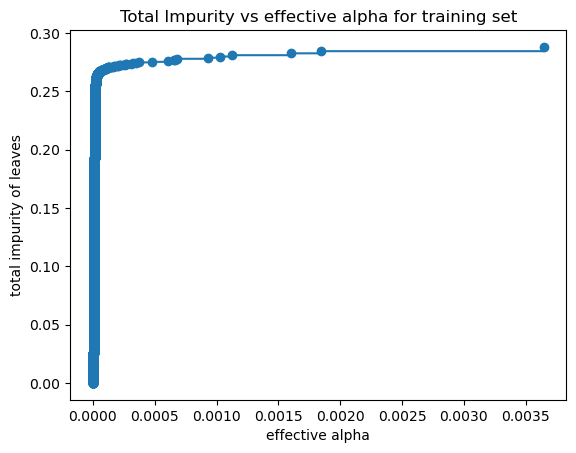

In [41]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

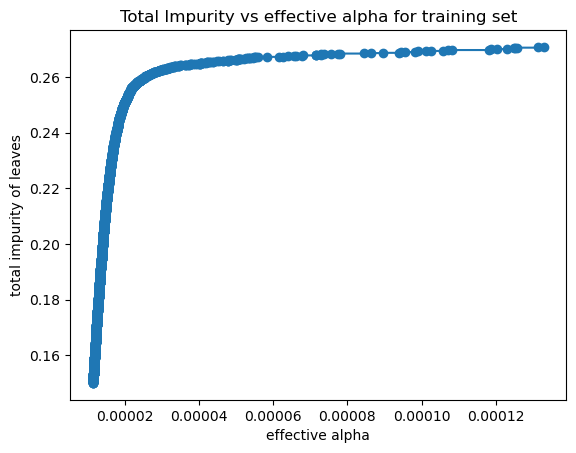

In [78]:
pur_zoom = impurities > .15
ccp_zoom = ccp_alphas < .00015
zoom = [p and c for p, c in zip(pur_zoom, ccp_zoom)]
fig, ax = plt.subplots()
ax.plot(ccp_alphas[zoom], impurities[zoom], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [135]:
print(min(ccp_alphas[zoom]))
print(max(ccp_alphas[zoom]))

1.1345888725595182e-05
0.0001329599474727515


In [96]:
alphas = [x * (10**-5) for x in range(5, 26, 5)]

In [97]:
clfs = []
for ccp_alpha in alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

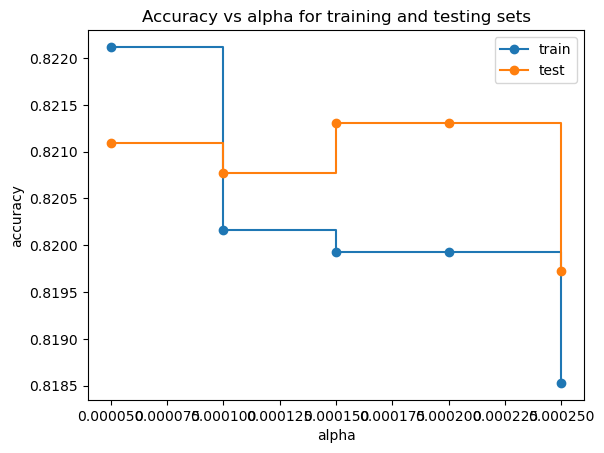

In [98]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [130]:
test_scores

[0.8210960252676484,
 0.8207678739899094,
 0.8213011198162353,
 0.8213011198162353,
 0.8197218917921162]

<BarContainer object of 5 artists>

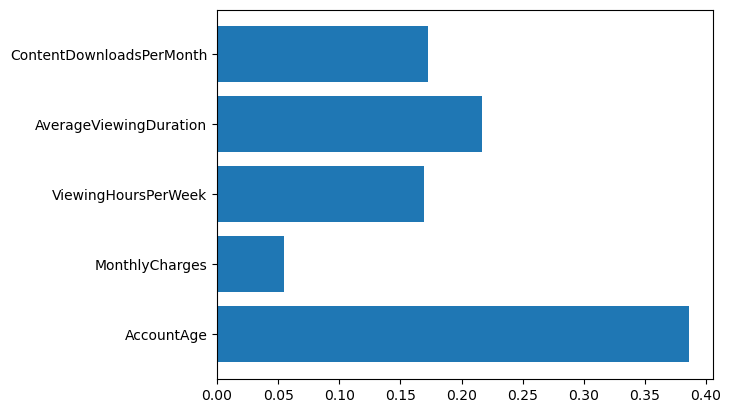

In [106]:
dt_y = clfs[3].feature_importances_
important = dt_y > 0
dt_x = X_train.columns
plt.barh(dt_x[important], dt_y[important])

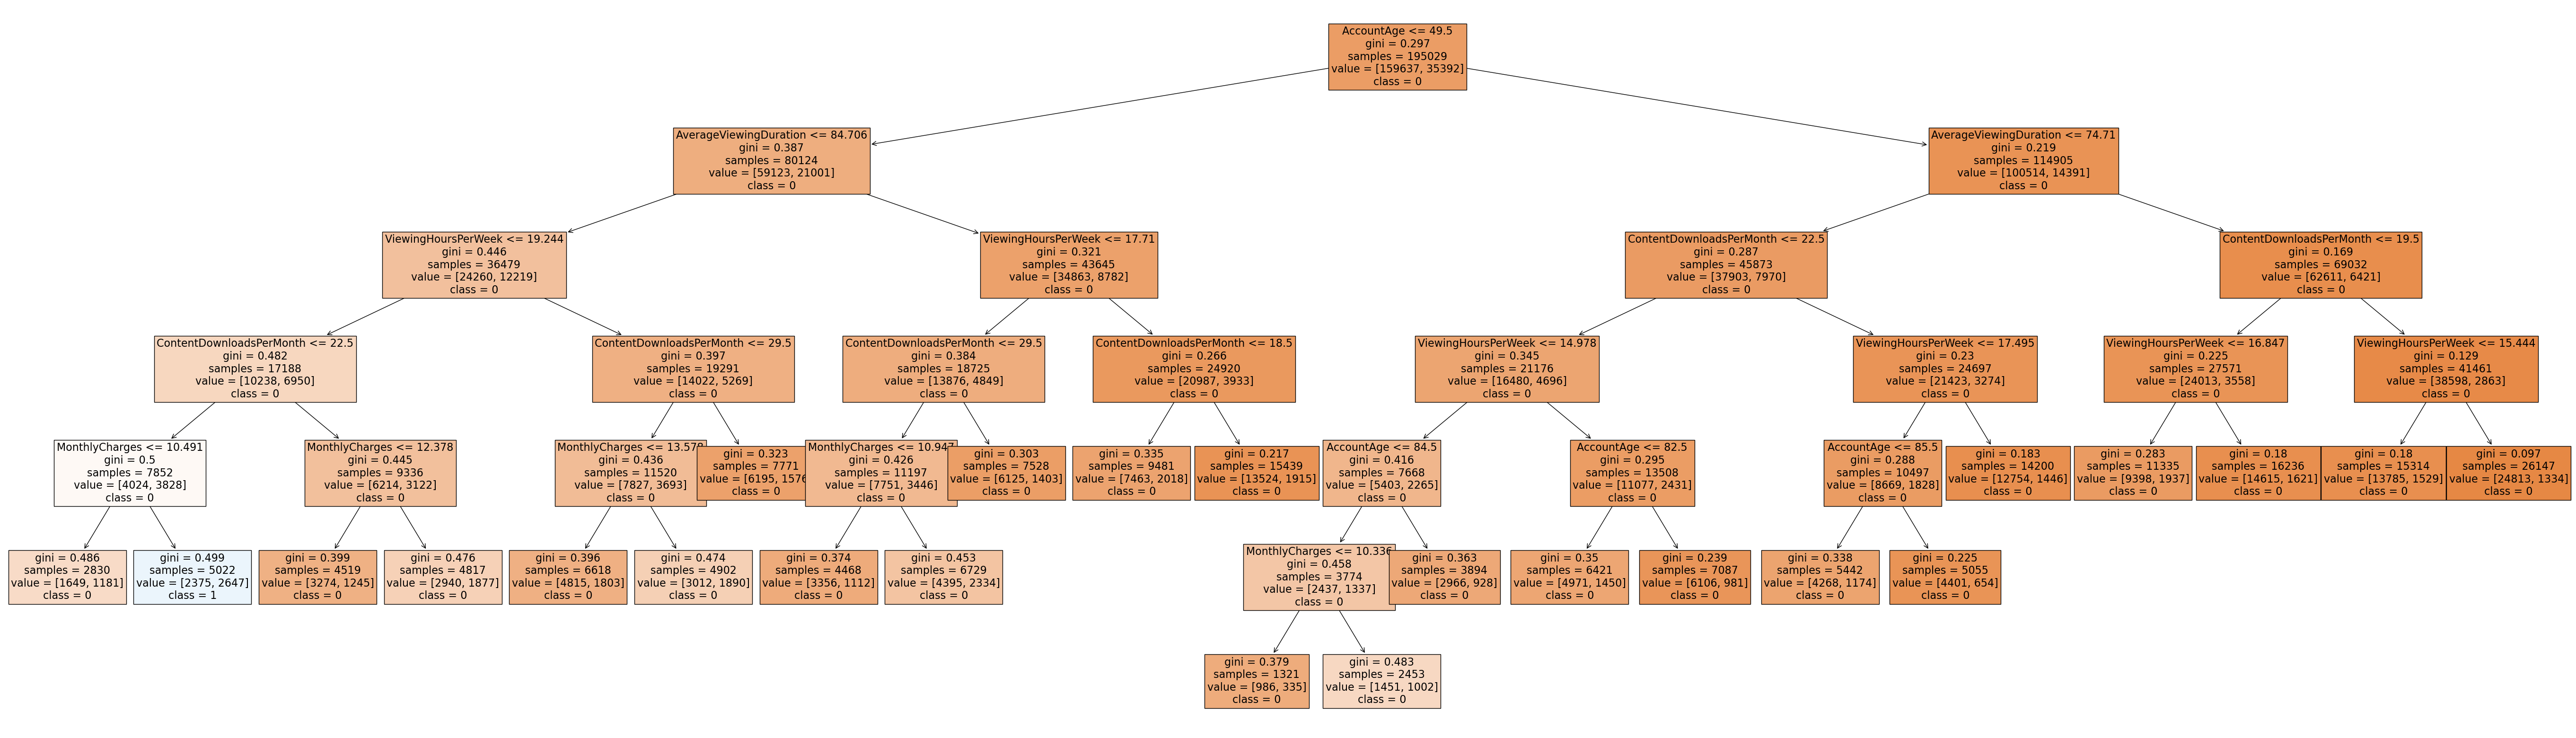

In [120]:
from sklearn import tree
post_prune_tree = clfs[3]
fig = plt.figure(figsize=(70,20)) # set a proper figure size (in case that the figure is too small to read or ratio is not proper)

tree.plot_tree(post_prune_tree, 
               feature_names = X_train.columns.values.tolist(), # specify variable names 
               class_names = ['0','1'], # specify class (Y) names
               filled = True, impurity = True, # whether to color the boxes, whether to report gini index
                fontsize = 16) # set fontsize to read
plt.show()

In [125]:
list(range(1000,10001,1000))

[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

In [126]:
# GridSearch + CV
from sklearn.model_selection import GridSearchCV

opt_tree = DecisionTreeClassifier(random_state = 0) # here, impurity measure is default, Gini. more efficient

# Multiple hyperparameters to tune
dt_params = {'max_depth':  range(1,8)         ,
             'min_samples_split':   [1000, 5000, 10000], # define the grid based on the sample size, larger numbers
             'max_leaf_nodes':    range(20,31, 2)  }

grid_tree = GridSearchCV(opt_tree, dt_params)
grid_tree.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': range(1, 8),
                         'max_leaf_nodes': range(20, 31, 2),
                         'min_samples_split': [1000, 5000, 10000]})

In [127]:
grid_tree.best_params_

{'max_depth': 6, 'max_leaf_nodes': 28, 'min_samples_split': 1000}

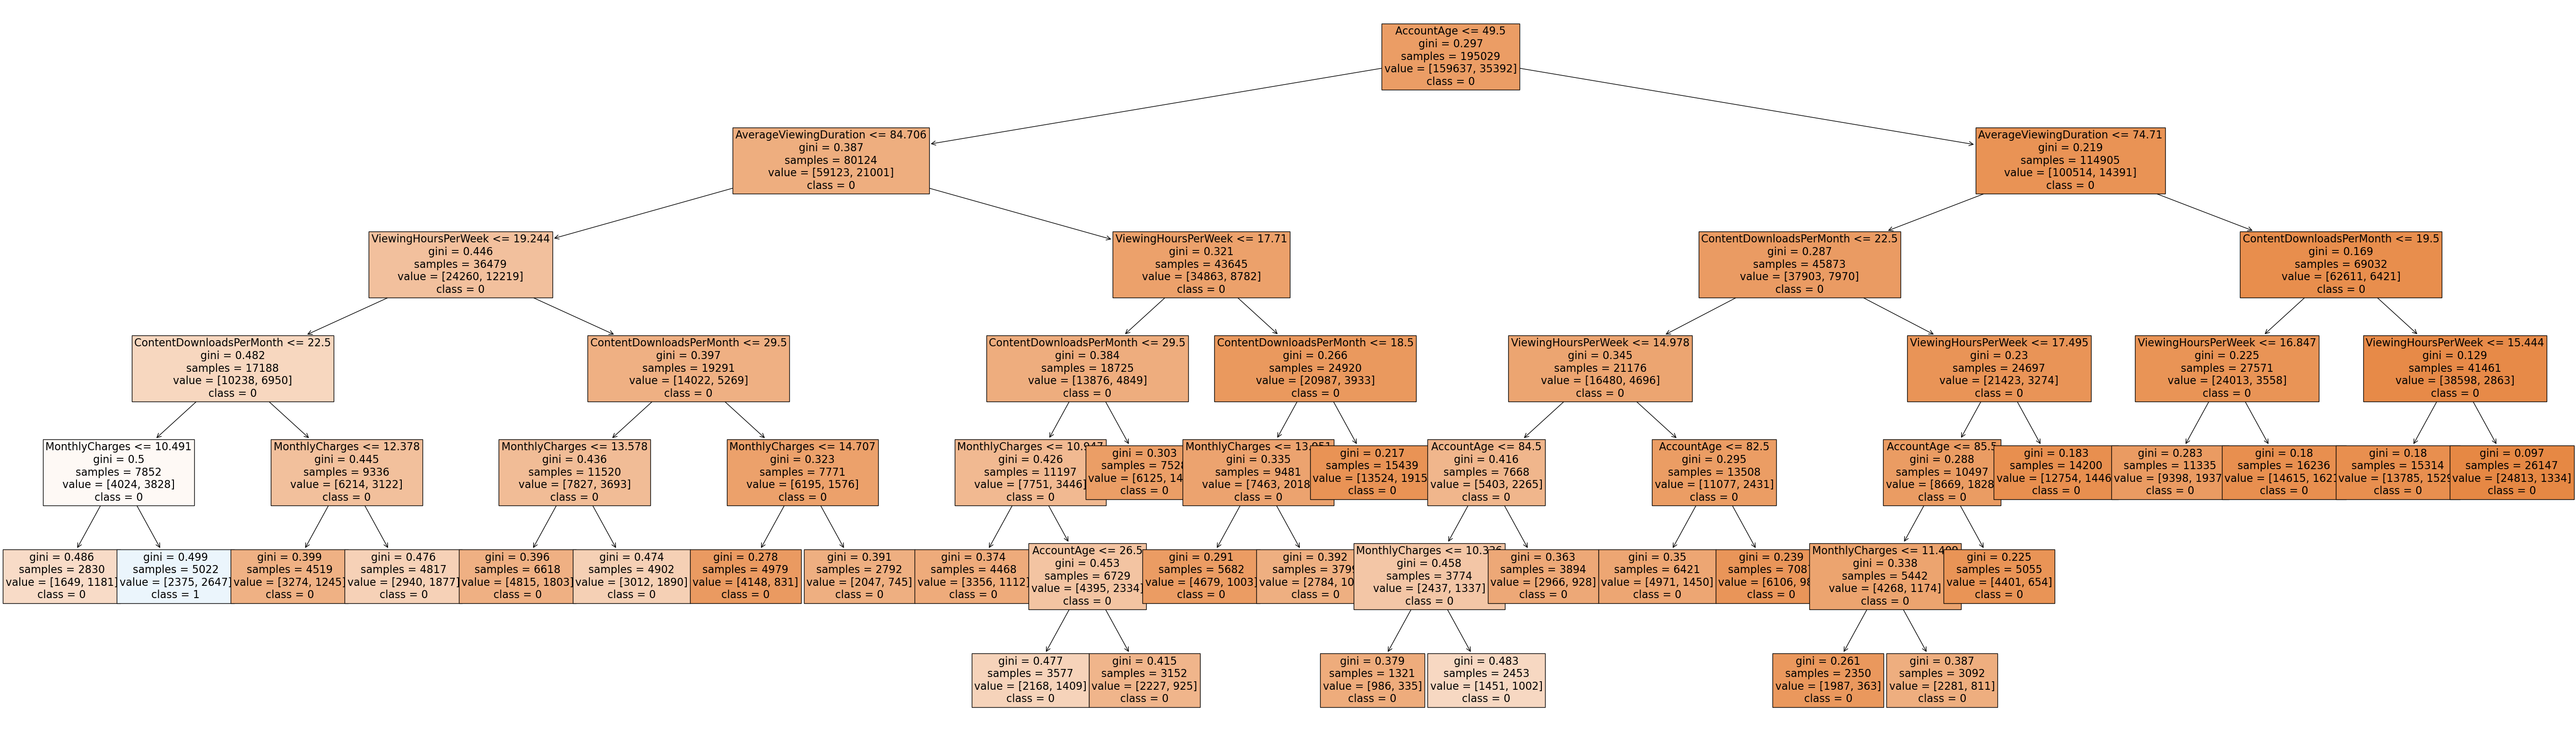

In [128]:
from sklearn import tree
post_prune_tree = grid_tree.best_estimator_
fig = plt.figure(figsize=(70,20)) # set a proper figure size (in case that the figure is too small to read or ratio is not proper)

tree.plot_tree(post_prune_tree, 
               feature_names = X_train.columns.values.tolist(), # specify variable names 
               class_names = ['0','1'], # specify class (Y) names
               filled = True, impurity = True, # whether to color the boxes, whether to report gini index
                fontsize = 16) # set fontsize to read
plt.show()

In [129]:
grid_tree.best_estimator_.score(X_test, y_test)

0.8213011198162353

In [132]:
five_tree = DecisionTreeClassifier(max_depth=5, random_state=0)
five_tree.fit(X_train, y_train)
five_tree.score(X_test, y_test)

0.8213011198162353

<BarContainer object of 5 artists>

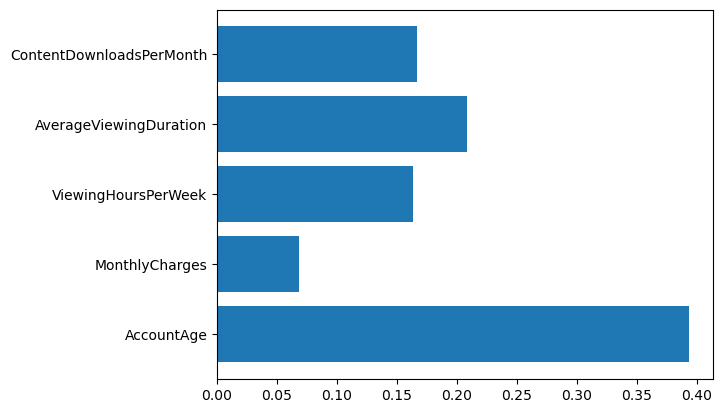

In [134]:
dt_y = five_tree.feature_importances_
important = dt_y > 0
dt_x = X_train.columns
plt.barh(dt_x[important], dt_y[important])